# Programming Exercise 8: Anomaly Detection and Recommender Systems

## Introduction 

In this exercise, you will implement the anomaly detection algorithm and apply it to detect failing servers on a network. 


In [1]:
%matplotlib inline

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import scipy.io
from sklearn import svm
from scipy.stats import multivariate_normal

import warnings
warnings.filterwarnings('ignore')

## 1. Anomaly detection

You will implement an anomaly detection algorithm to detect anomalous behavior in server computers. The features measure the throughput (mb/s) and latency (ms) of response of each server. While your servers were operating, you collected m = 307 examples of how they were behaving, and thus have an unlabeled dataset x(1) ... x(m). You suspect that the vast majority of these examples are 'normal', but there might also be some examples of servers acting anomalously within the dataset. 

You will use a Gaussian model to detect anomalous examples in your dataset. You will first start on a 2D dataset. After that, you will apply the anomaly detection algorithm to a larger dataset with many dimensions.

In [5]:
# load sample data:
data = scipy.io.loadmat('/Users/tess/Desktop/MachineLearning/machine-learning-ex8/ex8/ex8data1.mat')

X = data['X']
Xval = data['Xval']
yval = data['yval']

X.shape, Xval.shape, yval.shape

((307, 2), (307, 2), (307, 1))

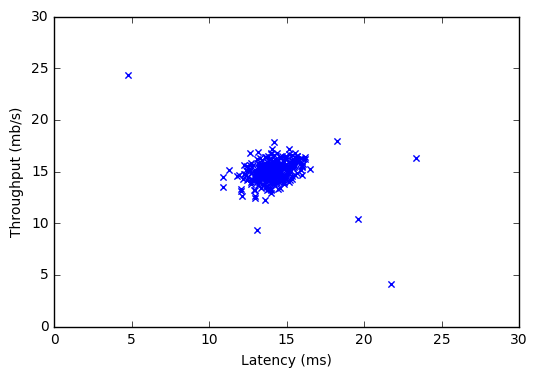

In [139]:
# visualize the example dataset

def plotData(X):
    plt.scatter(X[:, 0], X[:,1], c = 'blue', marker = 'x')
    plt.axis([0, 30, 0, 30])
    plt.xlabel('Latency (ms)')
    plt.ylabel('Throughput (mb/s)')
    return
plotData(X)

### 1.1 Gaussian distribution

To perform anomaly detection, you will first need to fit a model to the data's distribution

### 1.2 Estimating parameters for a gaussian

You can estimate the parameters mu and sigma squared for each feature in the dataset.

In [67]:
def estimateGaussian(X):
    k = X.shape[1]
    #mu = np.reshape(np.mean(X,axis = 0), (k,1))
    mu = np.mean(X,axis = 0)
    sigma2 = np.reshape(np.var(X, axis = 0), (k,1))
    #sigma2 = np.var(X, axis = 0)
    return mu, sigma2
mu, sigma2 = estimateGaussian(X)
mu.shape, sigma2.shape

((2,), (2, 1))

In [95]:
# Return the probability density of the multivariate normal at each
# data point (row) of X

def multivariateGaussian(X, mu, sigma2):
    k = len(mu)
    
    if sigma2.shape[1] == 1 or sigma2.shape[0] ==1:
        sigma2 = np.diag(sigma2.flatten())
    
    p = multivariate_normal.pdf(X, mu, sigma2)

    # alternatively, could do this by hand:
    #X = X - mu
    #p = (2*np.pi)**(-k/2)*np.linalg.det(sigma2) ** (-0.5) * \
    #np.exp(-0.5 * np.sum(np.dot(X, np.linalg.pinv(sigma2))*X, axis = 1))
    
    return p

In [92]:
p = multivariateGaussian(X, mu, sigma2)

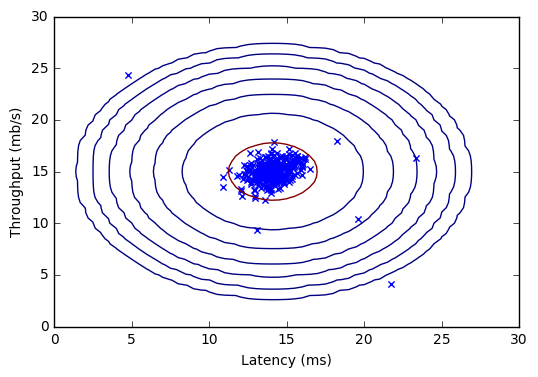

In [144]:
# visualize the fit

def visualizeFit(X, mu, sigma2):
    x = np.arange(0,30, 0.5)
    y = np.arange(0,30, 0.5)
    meshx, meshy = np.meshgrid(x,y)
    coordinates = [ entry.ravel() for entry in (meshx, meshy) ]
    points = np.vstack(coordinates).T
    
    Z = multivariateGaussian(points, mu, sigma2)
    Z = np.reshape(Z, (x.shape[0], x.shape[0]))

    plotData(X)
    plt.contour(meshx, meshy, Z, [10**exp for exp in range(-20,0,3)])
    return
visualizeFit(X, mu, sigma2)

### 1.3 Selecting the threshold Epsilon

Now that you ahve estimated the Gaussian parameters, you can investigate which examples have a very high probability given this distribution and which examples have a very low probability. The low probability examples are more likely to be the anomalies. One way to determine which examples are anomalies is to select a threshold based on a cross validation set.

In [238]:
def selectThreshold(yval, pval):
    bestEpsilon = 0
    bestF1 = 0
    F1 = 0


    stepsize = (np.max(pval) - np.min(pval)) / 1000
    evals = np.arange(np.min(pval), np.max(pval), stepsize)
    for epsilon in evals:
        predictions = (pval < epsilon).reshape((-1,1))
        X = np.hstack((predictions, yval))
        
        prec = np.sum([int(yval[x]) for x in xrange(predictions.shape[0]) \
                    if predictions[x]]) / float(np.sum(predictions))
        rec = np.sum([int(predictions[x]) for x in xrange(yval.shape[0]) \
                    if yval[x]]) / float(np.sum(yval))

        F1 = (2 * prec * rec) / (prec + rec)

        if F1 > bestF1:
            bestF1 = F1
            bestEpsilon = epsilon

    
    return bestEpsilon, bestF1

In [272]:
# should expect to see epsilon ~ 8.99e-05
pval = multivariateGaussian(Xval, mu, sigma2)
epsilon, F1 = selectThreshold(yval, pval)
print 'Best epsilon found using cross-validation: ', epsilon , '\n' \
'Best F1 on Cross Validation Set: ', F1

Best epsilon found using cross-validation:  8.99085277927e-05 
Best F1 on Cross Validation Set:  0.875


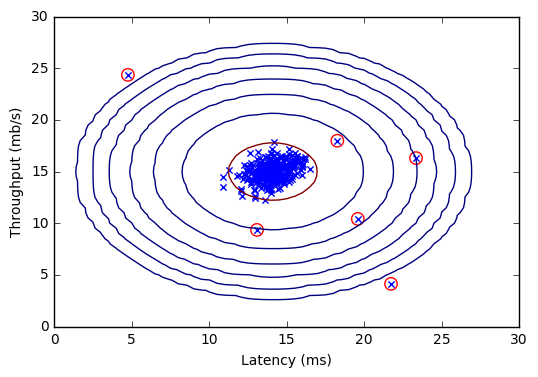

In [261]:
# run the anomaly detection code and circle the anomalies
outliers = np.where(p < epsilon)
visualizeFit(X, mu, sigma2)
plt.scatter(X[outliers, 0], X[outliers, 1],s=80, facecolors='none', edgecolors='r')

### 1.4 High dimesnional dataset

We will now run anomaly detection on a more realistic and much harder dataset. In this dataset, each example is described by 11 features, capturing many more properties of compute servers.

In [267]:
# load sample data:
hddata = scipy.io.loadmat('/Users/tess/Desktop/MachineLearning/machine-learning-ex8/ex8/ex8data2.mat')

hdX = hddata['X']
hdXval = hddata['Xval']
hdyval = hddata['yval']

hdX.shape, hdXval.shape, hdyval.shape

((1000, 11), (100, 11), (100, 1))

In [273]:
# estimate Gaussian parameters:
hdmu, hdsigma2 = estimateGaussian(hdX)

# find p for training set:
hdp = multivariateGaussian(hdX, hdmu, hdsigma2)

# find p for cross-validation set:
hdpval = multivariateGaussian(hdXval, hdmu, hdsigma2)

# find the best threshold
# expect to see epsilon ~ 1.38e-18
# and ~ 117 outliers
hdepsilon, hdF1 = selectThreshold(hdyval, hdpval)
print 'Best epsilon found using cross-validation: ', hdepsilon , '\n' \
'Best F1 on Cross Validation Set: ', hdF1, '\n', \
'Number of Outliers observed: ', sum(hdp < hdepsilon)

Best epsilon found using cross-validation:  1.37722889076e-18 
Best F1 on Cross Validation Set:  0.615384615385 
Number of Outliers observed:  117


## 2. Recommender Systems

In this part of the exercise, you will implement the collaborative filtering learning algorithm and apply it to a dataset of movie ratings. This dataset consists of ratings on a scale of 1 to 5. The dataset has n(u) = 943 users, and n(m) = 1682 movies.

### 2.1 Movie ratings datset

The matrix Y (a num_movies x num_users matrix) stores the ratings y(i,j) from 1 to 5. The matrix R is a binary-valued indicator matrix, where R(i,j) = 1 if user j gave a rating to movie i, and R(i,j) = 0 otherwise.

In [2]:
# load sample data:
movies = scipy.io.loadmat('/Users/tess/Desktop/MachineLearning/machine-learning-ex8/ex8/ex8_movies.mat')

R = movies['R']
Y = movies['Y']

R.shape, Y.shape

((1682, 943), (1682, 943))

In [3]:
# compute statistics like average rating
print 'Average rating for movie 1 (Toy Story): ', np.mean([ Y[0][x] for x in xrange(Y.shape[1]) if R[0][x]])

Average rating for movie 1 (Toy Story):  3.87831858407


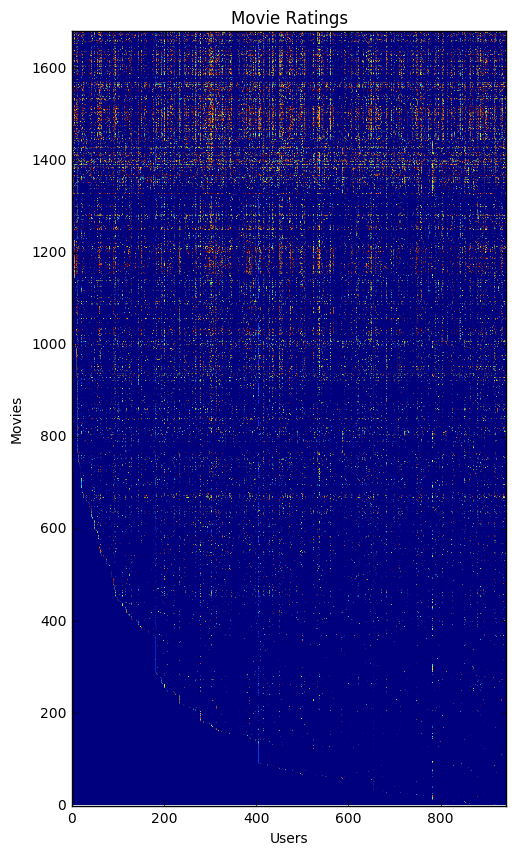

In [4]:
# visualize the ratings matrix by plotting with imagesc
fig, ax1 = plt.subplots(nrows=1, figsize=(6,10))

ax1.imshow(Y, extent=[0,943,0,1682])
ax1.set_title('Movie Ratings')
plt.xlabel('Users')
plt.ylabel('Movies')

Throughout this part of the exercise, you will also be working with the matrices X and Theta. The i-th row of X corresponds to the feature vector x(i) for the i-th movie, and the j-th row of Theta corresponds to one parameter vector theta(j) for the j-th user. Both x(i) and theta(j) are n-dimensional vectors. For the purposes of this exercise, you will use n = 100. Correspondingly, X is an n(m) X 100 matrix, and Theta is an n(u) x 100 matrix.

In [5]:
# load the pre-trained weights:
# (X, Theta, num_users, num_moves, num_features)
mat = scipy.io.loadmat('/Users/tess/Desktop/MachineLearning/machine-learning-ex8/ex8/ex8_movieParams.mat')

Theta = mat['Theta']
X = mat['X']
num_features = mat['num_features']
num_movies = mat['num_movies']
num_users = mat['num_users']

Theta.shape, X.shape, num_features.shape, num_movies.shape, num_users.shape

((943, 10), (1682, 10), (1, 1), (1, 1), (1, 1))

### 2.2 Collaborative filtering learning algorithm

In [20]:
# for now, reduce the data set size so that this runs faster
num_users = 4
num_movies = 5
num_features = 3
X = X[:num_movies, :num_features]
Y = Y[:num_movies,:num_users]
R = R[:num_movies, :num_users]
Theta = Theta[:num_users, :num_features]

X.shape, R.shape, Theta.shape, Y.shape

((5, 3), (5, 4), (4, 3), (5, 4))

#### 2.2.1 Collaborative filtering cost function

In [22]:
def cofiCostFunc(params, Y, R, num_users, num_movies, features, reg):
    
    # unfold the U and W matrices from params
    X = np.reshape(params[:num_movies*num_features], (num_movies,num_features))
    Theta = np.reshape(params[num_movies*num_features:], (num_users, num_features))

    J = (.5 * np.sum(((np.dot(Theta,X.T).T - Y) * R)**2) +   \
         ((reg / 2) * np.sum(Theta**2)) + ((reg / 2) * np.sum(X**2)))
    
    return J

# expect to see a cost of ~22.22 using loadd parameters 
XTparams = np.concatenate((X.flatten(),Theta.flatten()))
cofiCostFunc(XTparams, Y, R, num_users, num_movies, num_features, 0)

22.224603725685672

#### 2.2.2 Collaborative filtering gradient

In [47]:
def cofiGradient(params, Y, R, num_users, num_movies, num_features, reg):
    
    # unfold the U and W matrices from params
    X = np.reshape(params[:num_movies*num_features], (num_movies,num_features))
    Theta = np.reshape(params[num_movies*num_features:], (num_users, num_features))
    
    X_grad = np.dot((np.multiply(np.dot(X, Theta.T), R) - Y), Theta) + reg*X
    Theta_grad = np.dot((np.multiply(np.dot(X, Theta.T), R).T), X) + reg*Theta
    
    # flatten X_grad and Theta_grad and return as 1D array
    grads = np.concatenate((X_grad.flatten(),Theta_grad.flatten()))
    return grads

# expect to see a cost of ~22.22 using loadd parameters 
XTparams = np.concatenate((X.flatten(),Theta.flatten()))
grads = cofiGradient(XTparams, Y, R, num_users, num_movies, num_features, 0)
grads

array([-2.52899165,  7.57570308, -1.89979026, -0.56819597,  3.35265031,
       -0.52339845, -0.83240713,  4.91163297, -0.76677878, -0.38358278,
        2.26333698, -0.35334048, -0.80378006,  4.74271842, -0.74040871,
        3.75746358, -2.80407834,  3.16626337,  1.14375194, -0.43651417,
        1.30236991,  0.        ,  0.        ,  0.        ,  0.        ,
        0.        ,  0.        ])

In [44]:
# check gradients by comparing to numerical gradient estimation
def checkGradient(params, Y, R, num_users, num_movies, num_features, reg):
    
    print 'Numerical Gradient \t cofiGrad \t\t Difference'
    
    # Compute a numerical gradient with an epsilon perturbation vector
    eps = 0.0001
    n = len(params)
    epsvec = np.zeros(n)
    # These are my implemented gradient solutions
    grads = cofiGradient(params,Y,R,num_users, num_movies, num_features, reg)

    # Choose 10 random elements of my combined (X, Theta) param vector
    # and compute the numerical gradient for each... print to screen
    # the numerical gradient next to the my cofiGradient to inspect
    
    for i in xrange(10):
        idx = np.random.randint(0,n)
        epsvec[idx] = eps
        loss1 = cofiCostFunc(params-epsvec,Y,R,num_users, num_movies, num_features, reg)
        loss2 = cofiCostFunc(params+epsvec,Y,R,num_users, num_movies, num_features, reg)
        grad = (loss2 - loss1) / (2*eps)
        epsvec[idx] = 0
        print '%0.15f \t %0.15f \t %0.15f' % \
        (grad, grads[idx],grad - grads[idx])
    return
checkGradient(XTparams, Y, R, num_users, num_movies, num_features, 0)

Numerical Gradient 	 cofiGrad 		 Difference
1.164413669432207 	 -0.436514170453003 	 1.600927839885210
3.352650312837824 	 3.352650312849549 	 -0.000000000011725
-3.050990064075165 	 1.143751942994548 	 -4.194742007069713
0.000000000000000 	 0.000000000000000 	 0.000000000000000
0.000000000000000 	 0.000000000000000 	 0.000000000000000
-3.474107886738409 	 1.302369906874287 	 -4.776477793612696
-0.568195965531260 	 -0.568195965515757 	 -0.000000000015503
-0.803780061442438 	 -0.803780061452057 	 0.000000000009619
-10.568020204448914 	 3.757463578575254 	 -14.325483783024168
4.627760189990227 	 -2.804078339726888 	 7.431838529717114


In [ ]:
### hmmm. this doesn't look good.
# will return.